In [1]:
import os
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "3")
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import matplotlib as mpl
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from multiprocessing import Pool
import dynesty
import argparse
import pickle
import time

from util_funcs import *

In [2]:
generate_mocks = False
fit_mocks_sampling = False
plot_figs = True
save_figs = False
save_mocks = True
dynesty_analysis = False

cab_model = 'CURVED_ARC_SIS_MST'           
            # CAB model to be fitted with sampling
exp_time = 1200                            
            # JWST exposure time in seconds
num_pix = 100                              
            # Side length of square mock images in pixels
base_seed = 123                            
            # Base seed for reproducibility (-> source position, COSMOS source)
num_mocks_sets = 100 if generate_mocks else 1
            # Number of mock sets to be generated (3 lensed mocks in each set)

nparal = min(112, (num_pix // 10) * (num_pix // 10))
parallel_cores = nparal if generate_mocks or fit_mocks_sampling else 0
            # 0 to turn off multi-processing, positive int to specify cores

# Cluster lens parameters

M200, c_conc = 1e15, 4.0                   
            # Mass and concentration of cluster, from CDM mass-c relations 
z_lens, z_source = 0.4, 1.0                
            # Lens and source redshift
offset, width = 0.3, 0.6                  
            # Source placed between [offset, width] arcseconds from caustic curve

# Substructure parameters

substructure_model = 'NONE'
            # Dark matter model used to generate substructure (CDM, WDM, SIDM, or ULDM)
            # If NONE, smooth mocks with no substructure are generates
log10_dNdA = 0.0
            # Amplitude of projected SHMF estimated from Natarajan et al. 2017 (Figure 4)
log_m_host = np.log10(M200)
            # Substructure generated taking cluster halo as parant halo
log_mhigh = 8.
            # Upper bound on the subhalo mass rendered with pyHalo
log10_m_uldm = -22.0
            # log base 10 of the ULDM particle mass

out_dir = f'M=1e{int(np.log10(M200))}_c={int(c_conc)}_zl={z_lens}_zs={z_source}_o={offset}_w={width}_npix={num_pix}_exp={int(exp_time/60)}'

if substructure_model == "ULDM":

    out_dir += f'_uldm_m={log10_m_uldm}'

os.makedirs(out_dir, exist_ok=True)
            # Directory where mock image files will be saved

# Toy Cluster Model

We model a galaxy cluster with an elliptical NFW profile, with mass of $10^{15} M_{\odot}$, concentration of c=4, and ellipticity of 0.27 (from Shin et al. 2018). 

In [3]:

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=M200, c=c_conc)

lens_model_list_macro = ['NFW_ELLIPSE_CSE']
lens_model_macro = LensModel(lens_model_list_macro)
lens_ext_macro = LensModelExtensions(lens_model_macro)

kwargs_lens_macro = [{
    'Rs': Rs_angle,
    'alpha_Rs': alpha_Rs,
    'e1': 0.27,   # Average cluster ellipticity from Shin et al. 2018
    'e2': 0.0,
    'center_x': 0.0,
    'center_y': 0.0}]

# COSMOS Source

- Draw a COSMOS source galaxy, and convolve with a Gaussian to smooth out HST noise.
- Randomly place the source between inner and outer caustic lines on the source plane, but 0.2" away from the caustics, to avoid images that are very close to critical curves (where CAB lensing formalism fails).
- Compute the positions of lensed images formed from this source position.

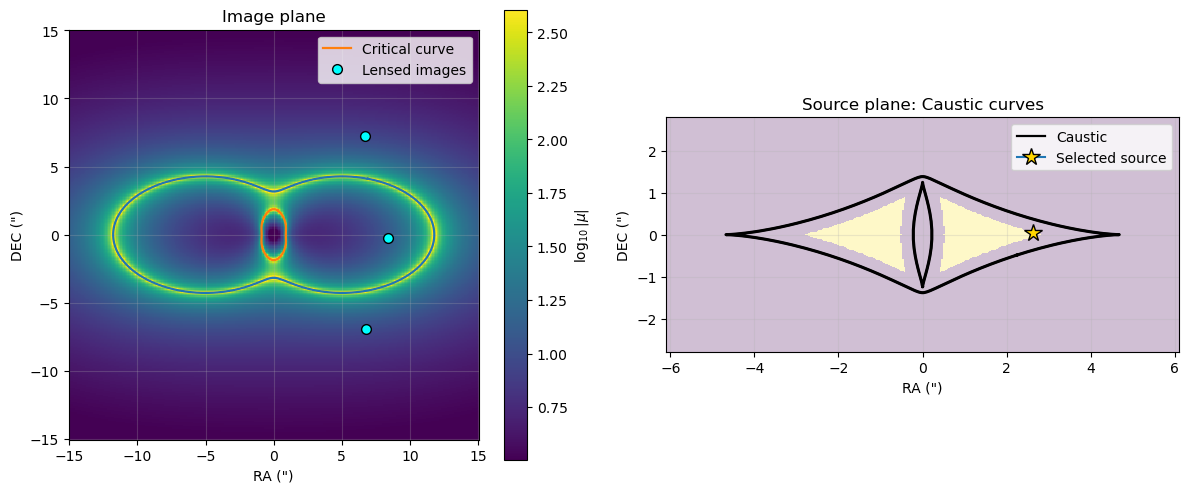

In [4]:
        
mock_set_idx = 0

base_seed += 1
random.seed(base_seed); np.random.seed(base_seed)

# Generate a random COSMOS source, smoothing out HST noise with a Gaussian
src_list, kwargs_source = get_source_kwargs(base_seed, z_source, smoothing_sigma=0.1)
src_model = LightModel(light_model_list=src_list)

# Generate a random source position between two caustic lines
(x_src, y_src, d,
 caustic_outer, caustic_inner, bbox, 
 ra_crit, dec_crit, ra_caus, dec_caus) = generate_source_pos(lens_ext_macro, kwargs_lens_macro,
                                                             offset, width, base_seed)

# Ray trace source position to find locations of 3 lensed images 
solver = LensEquationSolver(lens_model_macro)
x_imgs, y_imgs = solver.image_position_from_source(x_src, y_src, kwargs_lens_macro,
                                                   search_window=30.)

if plot_figs == True:
    visualize_source_selection(lens_model_macro, kwargs_lens_macro, caustic_inner, caustic_outer,
                               ra_caus, dec_caus, ra_crit, dec_crit, bbox,
                               offset, width, x_src, y_src, x_imgs, y_imgs, save_figs, out_dir, mock_set_idx)

# Mock image generation

We lens the COSMOS source with cluster+substructure lens model to generate a set of 3 lensed images. We do this by defining a custom local lens model centered at the image positions that returns angular deflections of the cluster model relative to image center — mapping (0, 0) on the source plane to (0, 0) on the image plane. We also add dark matter substructure with pyHalo (Gilman et al. 2020) symmetrically around (0, 0).

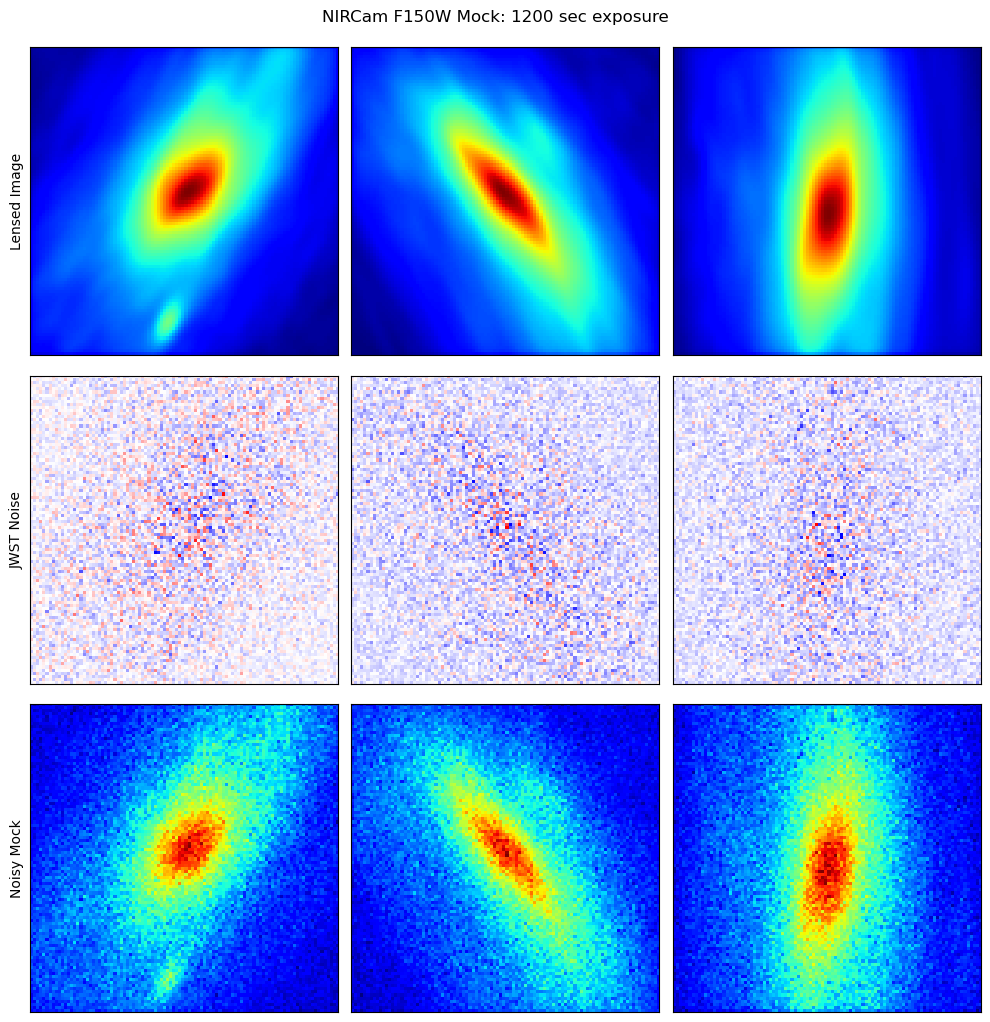

In [5]:
(lensed_imgs, noises, 
 mock_imgs, pixel_errors, 
 all_models_list, all_lenses_list) = generate_mock_set(cosmo, kwargs_lens_macro, kwargs_source,
                                                       Rs_angle, alpha_Rs,
                                                       x_imgs, y_imgs, z_lens, z_source,
                                                       substructure_model,
                                                       log10_dNdA, log_m_host, log_mhigh,
                                                       mock_set_idx, base_seed, exp_time, num_pix, out_dir,
                                                       parallel_cores = parallel_cores,
                                                       save_mocks = save_mocks,
                                                       plot_figs = plot_figs,
                                                       save_figs = save_figs,
                                                       log10_m_uldm = log10_m_uldm)

## Local maginfication fields
Visualize the local magnification fields around lensed image positions.

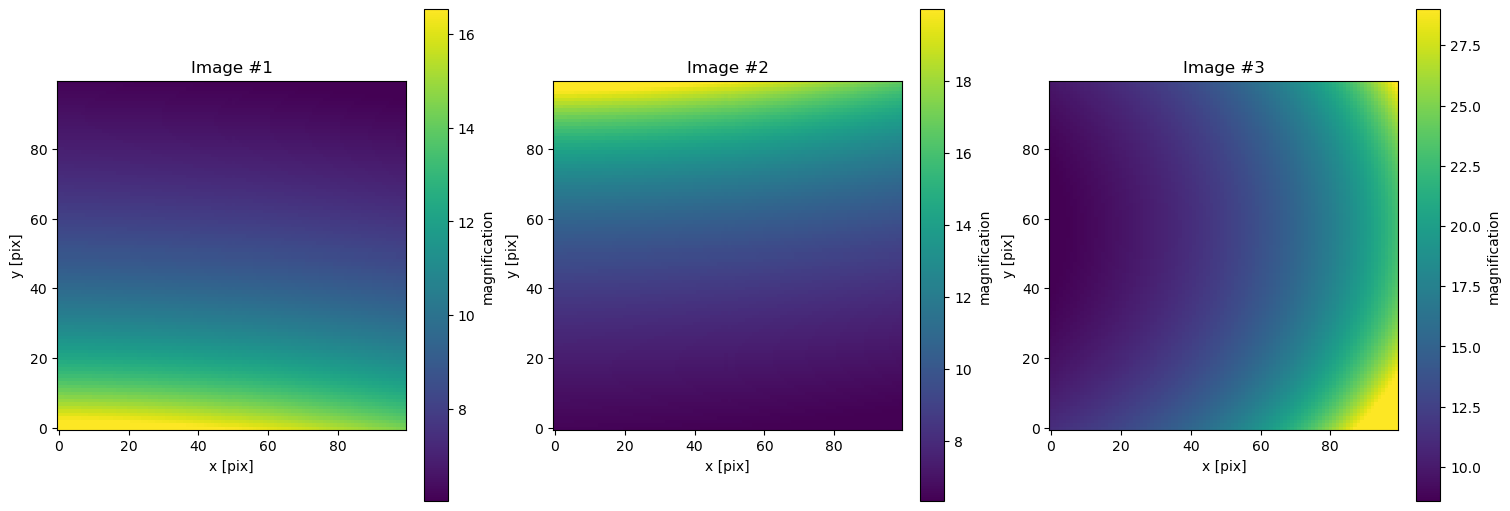

In [6]:
make_magnifications_plot(mock_set_idx, base_seed, num_pix, x_imgs, out_dir,
                         all_models_list, all_lenses_list, substructure_model,
                         parallel_cores = parallel_cores,
                         save_figs = save_figs)

# Estimate CAB parameters from global model
We numerically compute Curved Arc Basis (CAB) parameters from the global cluster model, at the positions of the lensed images. To get a quick approximation to the residual maps, we reconstruct lensed images using the *true* COSMOS source model, and a CAB model estimated parameters.

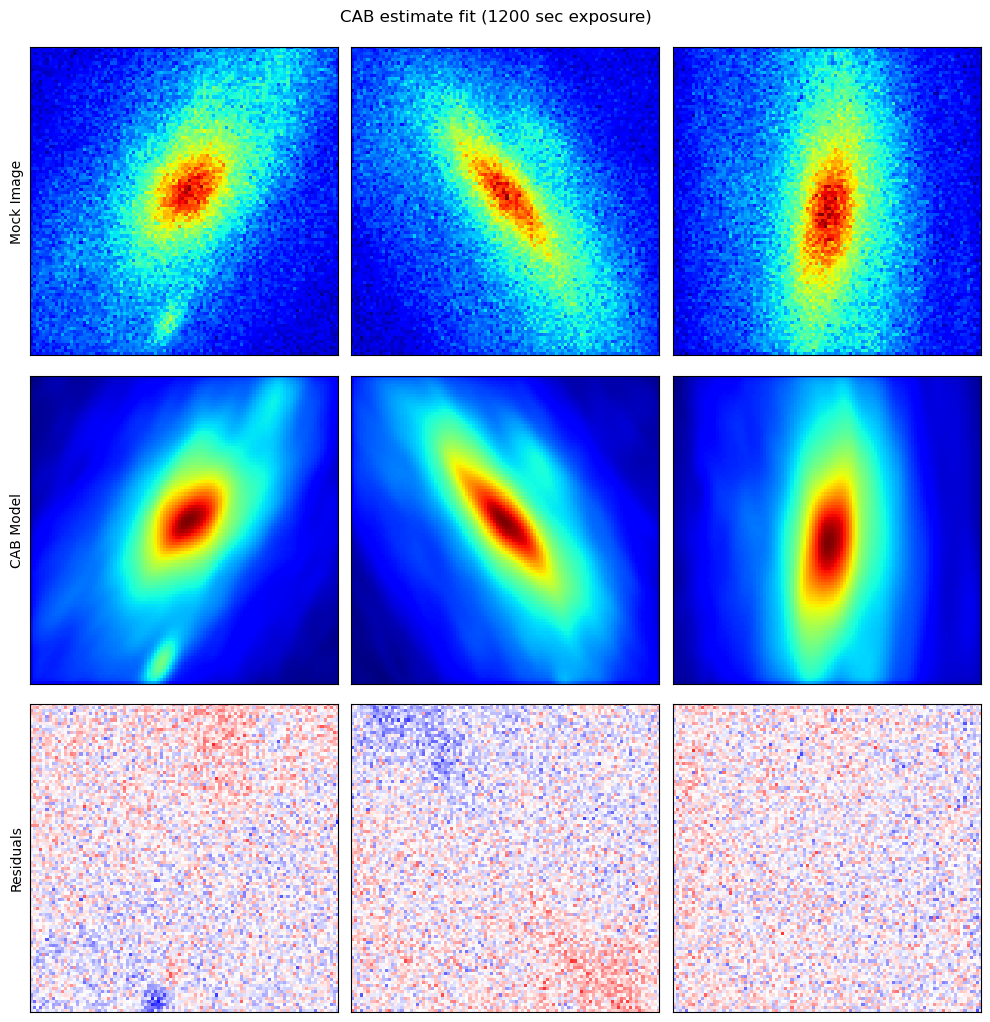

In [7]:
cab_lensed_imgs = []
all_cab_estimates = []

for i in range(len(x_imgs)):

    cab_lensed_img, all_cab_estimates = render_cab_est_imgs(i, lens_ext_macro,
                                                            x_imgs, y_imgs, 
                                                            kwargs_source, kwargs_lens_macro,
                                                            z_lens, z_source, cosmo, 
                                                            all_cab_estimates, num_pix, exp_time)
    cab_lensed_imgs.append(cab_lensed_img)

if plot_figs == True:

    visualize_cab_est_fit(substructure_model, mock_imgs, cab_lensed_imgs, pixel_errors,
                          save_figs, exp_time, out_dir, mock_set_idx)

if save_mocks:

    np.save(f"{out_dir}/subs={substructure_model}_set_#{mock_set_idx+1}_seed={base_seed}_cab_est_model.npy", cab_lensed_imgs)


# Fit lens model (with fixed source)

To get a more accurate, but an idealized residual map, we fix the COSMOS source model and sample CAB parameters.  

In [8]:
cab_bestf_imgs = []

for i in range(len(x_imgs)):

    kwargs_estimate = lens_ext_macro.curved_arc_estimate(x_imgs[i], y_imgs[i], kwargs_lens_macro)
    prior_width = 1.

    maxparam, minparam, npar = set_up_priors(kwargs_estimate, prior_width, cab_model)

    if fit_mocks_sampling == True:

        pool = Pool(nparal)

        logl_args = (i, cab_model, kwargs_source, 
                     z_lens, z_source, cosmo, exp_time,
                     mock_imgs, pixel_errors, num_pix)
        ptform_args = (minparam, maxparam)

        dsampler = dynesty.NestedSampler(lnlike, ptform, npar, pool=pool, queue_size=nparal,
                                        logl_args=logl_args, ptform_args=ptform_args)
        dsampler.run_nested(dlogz = 0.001)

        dresults = dsampler.results

        save_obj(dresults, f"{out_dir}/substructure_model={substructure_model}_{cab_model}_set#{mock_set_idx}_img#{i+1}_prior_width={prior_width}_dynesty_fit")

    elif dynesty_analysis == True:

        dresults = load_obj(f"{out_dir}/substructure_model={substructure_model}_{cab_model}_set#{mock_set_idx}_img#{i+1}_prior_width={prior_width}_dynesty_fit")

        lnl, bestfs, errs = bestfit(dresults)

        make_dynesty_cornerplot(dresults, i, cab_model, npar, bestfs, all_cab_estimates, exp_time)

        cab_bestf_img = render_cab_bestf_imgs(cab_model, kwargs_source, bestfs, z_source, z_lens, cosmo, num_pix, exp_time)

        cab_bestf_imgs.append(cab_bestf_img)


if plot_figs == True and dynesty_analysis == True:

    visualize_cab_dyn_fit(mock_imgs, cab_bestf_imgs, pixel_errors, save_figs, exp_time)
